In [1]:
import os
from PIL import Image
from torch.utils import data

class VocDetection(data.Dataset):
    """ `PASCAL VOC Detection <http://host.robots.ox.ac.uk/pascal/VOC/>`_ Dataset.
    Args:
        root (string):
            Root directory where images and annotations were downloaded
        imageFolder (string) :
            Path to images folder. image have extension as jpg, jpeg, png
        annotationFolder (string) :
            Path to annotation file folder. annotation file have extension as xml
        transform (callable, optional): A function/transform that  takes in an PIL image and label
            and returns a transformed version. E.g, ``transforms.ToTensor``
    """

    def __init__(self,
                 root,
                 image_folder="JPEGImages",
                 annotation_folder="Annotations",
                 resize_size=(416, 416),
                 transform=None):

        self.resize_size = resize_size

        image_path_list = self._get_list_of_filepath(root, image_folder)
        self.image_path_list = self.sort_ordered_by_filename(image_path_list)

        annotation_path_list = self._get_list_of_filepath(root, annotation_folder)
        self.annotation_path_list = self.sort_ordered_by_filename(annotation_path_list)

        classes_list = self._get_classes_list_from_dataset(self.annotation_path_list)
        classes_list_ordered_by_alphabet = sorted(classes_list)
        self.classes_list = classes_list_ordered_by_alphabet

        self.transform = transform

        assert self._is_validated_image_Extension(self.image_path_list)
        assert self._is_validated_annotation_Extension(self.annotation_path_list)
        assert len(self.image_path_list) == len(self.annotation_path_list)

    @staticmethod
    def sort_ordered_by_filename(path_list):
        assert isinstance(path_list, list)
        for path in path_list:
            assert isinstance(path, str)

        return sorted(path_list,
                   key=lambda filepath: int(filepath.split("/")[-1].split(".")[0]))

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: Tuple (image, target). target is the object returned by ``method``.
        """
        assert isinstance(index, int)

        image = Image.open(self.image_path_list[index]).convert('RGB')
        box_annotation_dict = self.__parse_voc(self.annotation_path_list[index])

        if self.transform:
            image, box_annotation_dict = self.transform([image, box_annotation_dict])

        target = self.__convert_box_label_to_yolo_label(box_annotation_dict, self.classes_list)
        image = image.resize(self.resize_size)

        return image, target


    def __len__(self):
        return len(self.image_path_list)

    @staticmethod
    def _get_classes_list_from_dataset(annotation_path_list):
        import xml.etree.ElementTree as Et

        assert isinstance(annotation_path_list, list)
        for annotation_path in annotation_path_list:
            assert isinstance(annotation_path, str)
        assert annotation_path_list

        classes_list = list()
        for annotation_path in annotation_path_list:
            xml_file = open(annotation_path, "r")
            tree = Et.parse(xml_file)

            element_list = list()
            for elem in tree.iter():
                element_list.append(elem.tag)

            assert "name" in element_list

            root = tree.getroot()

            objects = root.findall("object")
            assert objects

            for _object in objects:
                cls_tag = _object.find("name")
                cls = cls_tag.text
                if cls not in classes_list:
                    classes_list.append(cls)

                classes_list = list(filter(None, classes_list))

        return classes_list

    def __convert_box_label_to_yolo_label(self, label, classes_list):
        assert isinstance(label, dict)
        assert isinstance(classes_list, list)
        for cls in classes_list:
            assert isinstance(cls, str)

        root_keys = label.keys()
        size_keys = label["size"].keys()
        number_of_objects = len(label["object"])

        assert "size" in root_keys
        assert "object" in root_keys
        assert "width" in size_keys
        assert "height" in size_keys
        assert number_of_objects != 0

        yolo_label = list()

        image_size = {
            "width": float(label["size"]["width"]),
            "height": float(label["size"]["height"]),
        }

        for _object in label["object"]:
            _object_keys = _object.keys()
            assert "name" in _object_keys
            assert "xmin" in _object_keys
            assert "ymin" in _object_keys
            assert "xmax" in _object_keys
            assert "ymax" in _object_keys

            name = _object["name"]
            cls = float(classes_list.index(name))
            box_coordinate = {
                "xmin": float(_object["xmin"]),
                "ymin": float(_object["ymin"]),
                "xmax": float(_object["xmax"]),
                "ymax": float(_object["ymax"]),
            }

            yolo_coordinate = self.__convert_coordinate(image_size, box_coordinate)
            yolo_coordinate.insert(0, cls)
            yolo_label.append(yolo_coordinate)

        return yolo_label

    @staticmethod
    def __convert_coordinate(image_size, box_coordinate):
        image_size_keys = image_size.keys()
        box_coordinate_keys = box_coordinate.keys()
        assert "width" in image_size_keys
        assert "height" in image_size_keys
        assert "xmin" in box_coordinate_keys
        assert "ymin" in box_coordinate_keys
        assert "xmax" in box_coordinate_keys
        assert "ymax" in box_coordinate_keys
        assert isinstance(image_size, dict)
        assert isinstance(box_coordinate, dict)
        assert isinstance(image_size["width"], float)
        assert isinstance(image_size["height"], float)
        assert isinstance(box_coordinate["xmin"], float)
        assert isinstance(box_coordinate["ymin"], float)
        assert isinstance(box_coordinate["xmax"], float)
        assert isinstance(box_coordinate["ymax"], float)

        x_of_box = (box_coordinate["xmin"] + box_coordinate["xmax"]) / 2.0
        y_of_box = (box_coordinate["ymin"] + box_coordinate["ymax"]) / 2.0
        width_of_box = box_coordinate["xmax"] - box_coordinate["xmin"]
        height_of_box = box_coordinate["ymax"] - box_coordinate["ymin"]

        relative_x_of_center = x_of_box / image_size["width"]
        relative_y_of_center = y_of_box / image_size["height"]
        relative_box_width = width_of_box / image_size["width"]
        relative_box_height = height_of_box / image_size["height"]

        return [relative_x_of_center, relative_y_of_center,
                relative_box_width, relative_box_height]

    @staticmethod
    def __parse_voc(annotation_path):
        import xml.etree.ElementTree as Et
        assert isinstance(annotation_path, str)

        xml_file = open(annotation_path, "r")
        tree = Et.parse(xml_file)

        element_list = list()
        for elem in tree.iter():
            element_list.append(elem.tag)

        assert "size" in element_list
        assert "width" in element_list
        assert "height" in element_list
        assert "object" in element_list
        assert "name" in element_list
        assert "bndbox" in element_list
        assert "xmin" in element_list
        assert "ymin" in element_list
        assert "xmax" in element_list
        assert "ymax" in element_list

        result = dict()
        root = tree.getroot()

        size_tag = root.find("size")

        result["size"] = {
            "width": size_tag.find("width").text,
            "height": size_tag.find("height").text,
            "depth": size_tag.find("depth").text
        }

        result["object"] = list()

        objects = root.findall("object")
        assert objects

        for _object in objects:

            result["object"].append({
                "name": _object.find("name").text,
                "xmin": _object.find("bndbox").find("xmin").text,
                "ymin": _object.find("bndbox").find("ymin").text,
                "xmax": _object.find("bndbox").find("xmax").text,
                "ymax": _object.find("bndbox").find("ymax").text
            })

        return result


    @staticmethod
    def _get_list_of_filepath(root_directory, sub_directory):
        assert isinstance(root_directory, str)
        assert isinstance(sub_directory, str)

        (dir_path, _, filenames) = \
            next(os.walk(os.path.abspath(os.path.join(root_directory, sub_directory))))
        return [os.path.join(dir_path, filename) for filename in filenames]


    def _is_validated_annotation_Extension(self, annotation_path_list):
        assert isinstance(annotation_path_list, list)
        for path in annotation_path_list:
            assert isinstance(path, str)

        validation_list_about_xml = self.__is_validated_extension(annotation_path_list, "xml")

        return self.__is_all_element_validated(validation_list_about_xml)


    def _is_validated_image_Extension(self, image_path_list):
        assert isinstance(image_path_list, list)
        for path in image_path_list:
            assert isinstance(path, str)

        validation_list_about_jpg = self.__is_validated_extension(image_path_list, "jpg")
        validation_list_about_jpeg = self.__is_validated_extension(image_path_list, "jpeg")
        validation_list_about_png = self.__is_validated_extension(image_path_list, "png")


        integrated_validation_list = \
            self.__is_supported_image_extension(jpg_validations=validation_list_about_jpg,
                                                jpeg_validations=validation_list_about_jpeg,
                                                png_validations=validation_list_about_png)

        return self.__is_all_element_validated(integrated_validation_list)


    @staticmethod
    def __is_all_element_validated(validation_list):
        assert isinstance(validation_list, list)
        for validation_value in validation_list:
            assert isinstance(validation_value, bool)

        intergated_validation = True

        for validation in validation_list:
            intergated_validation = intergated_validation and validation

        return intergated_validation


    @staticmethod
    def __is_supported_image_extension(**kwargs):
        keys = kwargs.keys()
        assert "jpg_validations" in keys
        assert "jpeg_validations" in keys
        assert "png_validations" in keys

        validations = list()
        for key in keys:
            validations.append(kwargs[key])

        # Integrate all validation
        # initial list was selected last of validation list
        # because of last of validation list not selected for loop
        result = validations[-1]

        for i in range(len(validations) - 1):
            result = [result[j] or validations[i][j] for j in range(len(result))]

        return result


    @staticmethod
    def __is_validated_extension(file_list, extension):
        assert isinstance(file_list, list)
        assert isinstance(extension, str)

        return [filename[-3:].lower() == extension for filename in file_list]

In [2]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
plt.ion()   # interactive mode

def visualize_detection_label(image, coordinates, classes_list, grid_size, mode="yolo"):
    assert image
    assert coordinates
    assert classes_list
    assert isinstance(classes_list, list)
    assert isinstance(grid_size, tuple)
    assert len(grid_size) == 2
    assert isinstance(image, Image.Image)

    draw = ImageDraw.Draw(image)
    draw_grid(draw, image.size, grid_size)

    if mode == "yolo":
        assert isinstance(coordinates, list)
        for coordinate in coordinates:
            assert len(coordinate) == 5
            for element in coordinate:
                assert isinstance(element, float)

        for coordinate in coordinates:
            draw_yolo_information(draw, coordinate, image.size, classes_list)
    elif mode == "box":
        draw_box_information(draw, coordinates)


    plt.figure(figsize=(10,10))
    plt.imshow(image)
    plt.show()
    plt.close()

def draw_grid(draw_image_obj, image_size, grid_size):
    assert isinstance(draw_image_obj, ImageDraw.ImageDraw)
    assert isinstance(image_size, tuple)
    assert isinstance(grid_size, tuple)
    assert len(image_size) == 2
    assert len(grid_size) == 2

    image_width, image_height = image_size
    grid_width, grid_height = grid_size

    dx = image_width // grid_width
    dy = image_height // grid_height

    for i in range(0, image_width, dx):
        y_axis_line = ((i, 0), (i, image_height))
        draw_image_obj.line(y_axis_line, fill="red")

    for i in range(0, image_height, dy):
        x_axis_line = ((0, i), (image_width, i))
        draw_image_obj.line(x_axis_line, fill="red")

def convert_yolo_label_to_box_label(coordinate, image_size, classes_list):
    assert isinstance(coordinate, list)
    assert len(coordinate) == 5
    for element in coordinate:
        assert isinstance(element, float)
    assert isinstance(image_size, tuple)
    assert isinstance(classes_list, list)
    for cls in classes_list:
        isinstance(cls, str)

    image_width, image_height = image_size

    cls = classes_list[int(coordinate[0])]
    x_of_center = int(coordinate[1] * image_width)
    y_of_center = int(coordinate[2] * image_height)
    width = coordinate[3] * image_width
    height = coordinate[4] * image_height

    xmin = int(x_of_center - (width / 2))
    ymin = int(y_of_center - (height / 2))
    xmax = int(xmin + width)
    ymax = int(ymin + height)

    return [cls, xmin, ymin, xmax, ymax]

def draw_box_information(draw_image_obj, coordinates):

    for _object in coordinates["object"]:
        cls = _object["name"]
        xmin = int(_object["xmin"])
        ymin = int(_object["ymin"])
        xmax = int(_object["xmax"])
        ymax = int(_object["ymax"])
        draw_image_obj.rectangle(((xmin, ymin), (xmax, ymax)), outline="blue")
        draw_image_obj.text((xmin, ymin), cls)

def draw_yolo_information(draw_image_obj, coordinate, image_size, classes_list):
    assert isinstance(draw_image_obj, ImageDraw.ImageDraw)
    assert isinstance(image_size, tuple)
    assert isinstance(coordinate, list)
    assert len(coordinate) == 5
    for element in coordinate:
        assert isinstance(element, float)

    image_width, image_height = image_size

    x_of_center = int(coordinate[1] * image_width)
    y_of_center = int(coordinate[2] * image_height)

    cls, xmin, ymin, xmax, ymax = \
        convert_yolo_label_to_box_label(coordinate, image_size, classes_list)

    draw_image_obj.rectangle(((xmin, ymin), (xmax, ymax)), outline="blue")
    draw_image_obj.ellipse(((x_of_center - 2, y_of_center - 2),
                  (x_of_center + 2, y_of_center + 2)),
                 fill='blue')
    draw_image_obj.text((xmin, ymin), cls)

In [3]:
import torchvision.transforms as transforms
from imgaug import augmenters as iaa

<PIL.Image.Image image mode=RGB size=416x416 at 0x7F4B5D4ADE48> [[14.0, 0.5380658436213992, 0.452, 0.360082304526749, 0.5]]


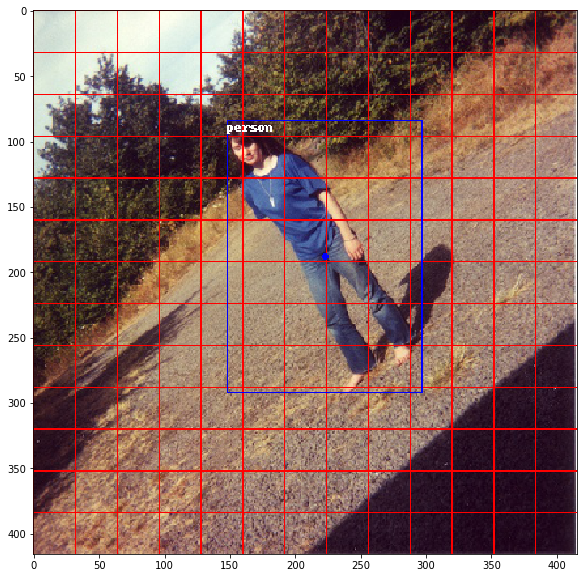

<PIL.Image.Image image mode=RGB size=416x416 at 0x7F4B5A386C88> [[0.0, 0.479, 0.46441281138790036, 0.542, 0.3736654804270463], [0.0, 0.33, 0.37544483985765126, 0.128, 0.12455516014234876], [14.0, 0.408, 0.7277580071174378, 0.036, 0.17437722419928825], [14.0, 0.07, 0.7597864768683275, 0.036, 0.17437722419928825]]


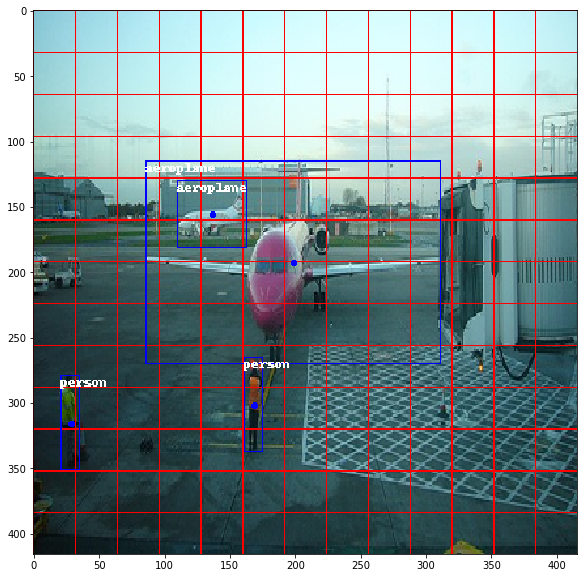

<PIL.Image.Image image mode=RGB size=416x416 at 0x7F4B5CEE9F98> [[0.0, 0.508, 0.505464480874317, 0.98, 0.4262295081967213], [0.0, 0.903, 0.5819672131147541, 0.122, 0.07103825136612021], [0.0, 0.736, 0.5614754098360656, 0.172, 0.09562841530054644]]


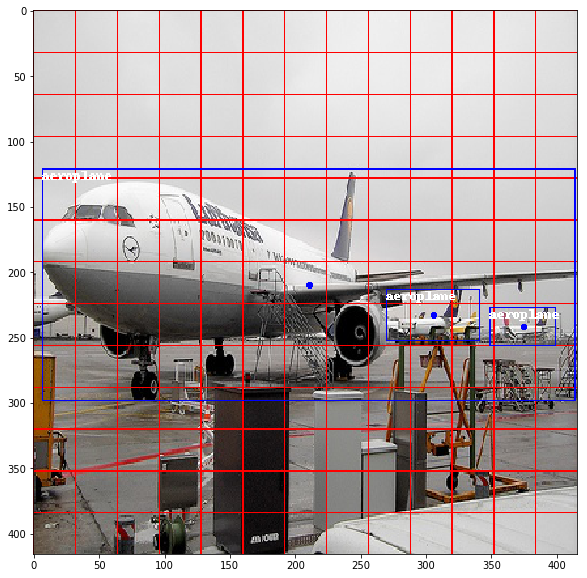

<PIL.Image.Image image mode=RGB size=416x416 at 0x7F4B5CF1F4E0> [[19.0, 0.5, 0.49066666666666664, 0.376, 0.5066666666666667]]


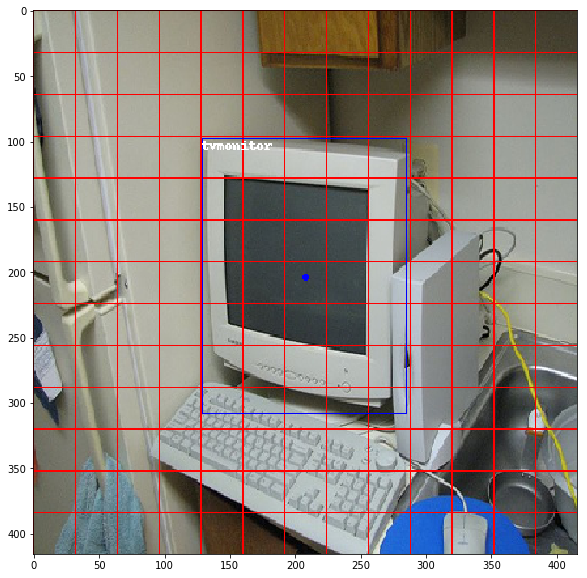

<PIL.Image.Image image mode=RGB size=416x416 at 0x7F4B5CECEDD8> [[18.0, 0.763, 0.4880597014925373, 0.474, 0.7850746268656716], [18.0, 0.236, 0.5, 0.468, 0.7850746268656716]]


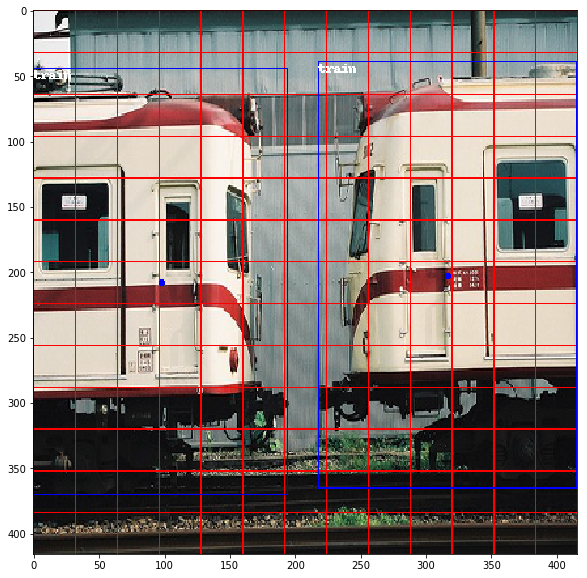

<PIL.Image.Image image mode=RGB size=416x416 at 0x7F4B5CDF8F28> [[3.0, 0.711, 0.43543543543543545, 0.326, 0.8048048048048048], [3.0, 0.465, 0.6996996996996997, 0.194, 0.11411411411411411]]


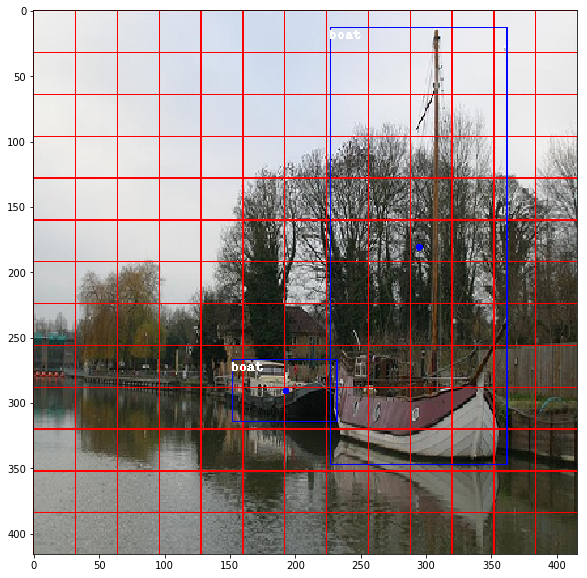

<PIL.Image.Image image mode=RGB size=416x416 at 0x7F4B5CE2F208> [[11.0, 0.502, 0.52, 0.512, 0.4266666666666667], [8.0, 0.503, 0.5013333333333333, 0.706, 0.9973333333333333]]


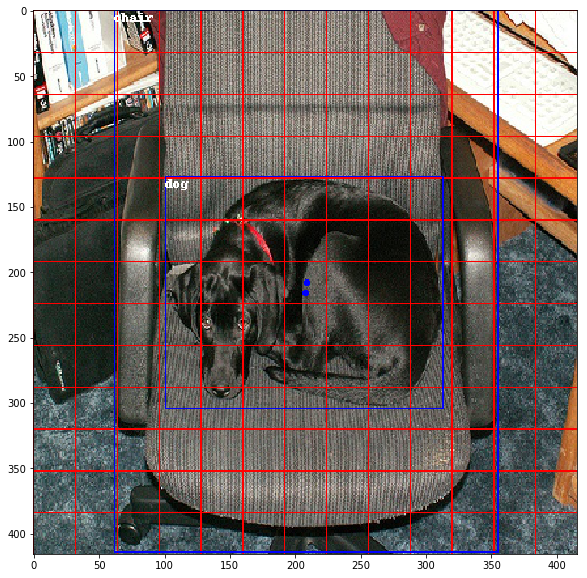

<PIL.Image.Image image mode=RGB size=416x416 at 0x7F4B5D4F0860> [[2.0, 0.293, 0.56, 0.478, 0.88]]


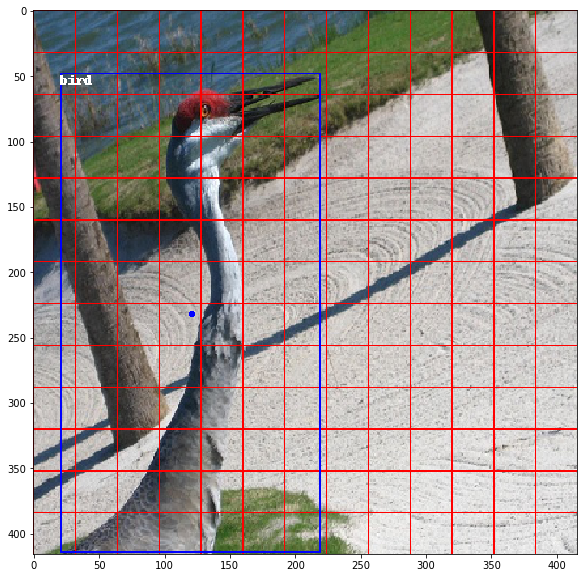

<PIL.Image.Image image mode=RGB size=416x416 at 0x7F4B5CED89E8> [[19.0, 0.726, 0.3933333333333333, 0.448, 0.6373333333333333], [19.0, 0.273, 0.4013333333333333, 0.458, 0.6533333333333333]]


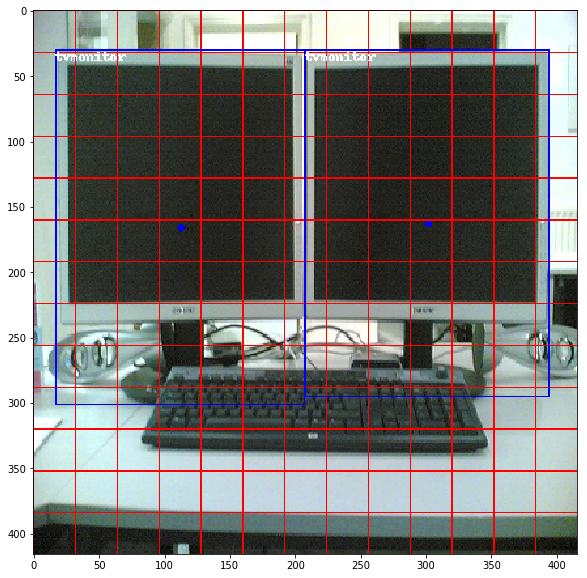

<PIL.Image.Image image mode=RGB size=416x416 at 0x7F4B5D4A6940> [[18.0, 0.359, 0.488, 0.714, 0.8373333333333334]]


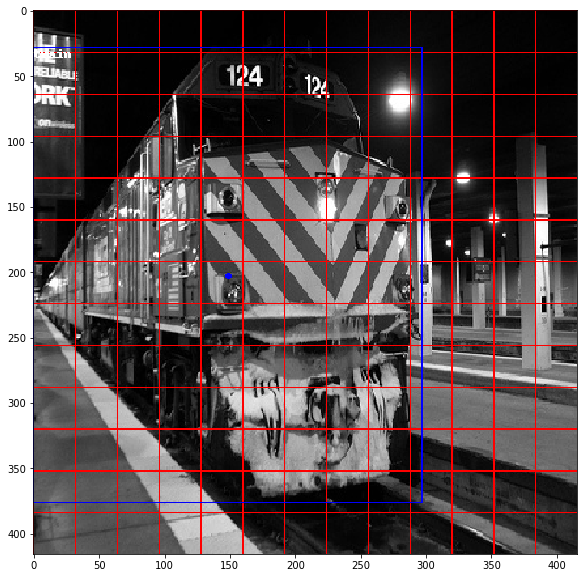

In [11]:
root = "/home/keti-1080ti/Documents/dev/DeepBaksu_vision/_Datasets/VOCdevkit"

# Dataset class demo
voc = VocDetection(root)
for i in range(10):
    image, target = voc.__getitem__(i)
    print(image, target)
    visualize_detection_label(image, target, voc.classes_list, (13, 13))

In [12]:
import numpy as np
import imgaug as ia
from PIL import Image

class Augmenter():

    # Should be implementated
    def __init__(self, seq):
        self.seq = seq

    # Should be implementated
    def __call__(self, img_and_annotation):

        image = img_and_annotation[0]
        box_annotation_dict = img_and_annotation[1]

        # PIL image convert to numpy image
        image = np.array(image)
        image_aug, bbs_aug = self.augment_image(image, box_annotation_dict, self.seq)
        
        # numpy image convert to PIL image
        image_aug = Image.fromarray(image_aug)

        return image_aug, bbs_aug

    def augment_image(self, image, box_annotation_dict, seq):
        # convert imgaug label style
        bbs = self.transform_imgaug_style_boxes(box_annotation_dict)
        
        # The deterministic sequence will always apply the exactly same effects to the images.
        seq_det = seq.to_deterministic()

        # it can apply same augmentation effect to image & label
        image_aug = seq_det.augment_images([image])[0]
        bbs_aug = seq_det.augment_bounding_boxes([bbs])[0]
        
        # remove out of region
        bbs_aug = bbs_aug.remove_out_of_image().cut_out_of_image()
        
        # convert origin label style
        augmented_box = self.transofrm_annotation_information_style(box_annotation_dict, bbs_aug)

        return image_aug, augmented_box

    @staticmethod
    def transofrm_annotation_information_style(box_annotation_dict, bbs_aug):
        assert isinstance(box_annotation_dict, dict)

        box_annotation_keys = box_annotation_dict.keys()
        assert "size" in box_annotation_keys
        assert "object" in box_annotation_keys

        size_tag_keys = box_annotation_dict["size"].keys()
        assert "width" in size_tag_keys
        assert "height" in size_tag_keys
        assert "depth" in size_tag_keys

        assert isinstance(box_annotation_dict["object"], list)
        for _object in box_annotation_dict["object"]:
            _object_keys = _object.keys()
            assert "name" in _object_keys
            assert "xmin" in _object_keys
            assert "ymin" in _object_keys
            assert "xmax" in _object_keys
            assert "ymax" in _object_keys

        assert isinstance(bbs_aug, ia.BoundingBoxesOnImage)

        objects = box_annotation_dict["object"]
        objects.clear()

        for i in range(len(bbs_aug.bounding_boxes)):
            augmented_box = bbs_aug.bounding_boxes[i]
            objects.append(
                {
                    "name": augmented_box.label,
                    "xmin": augmented_box.x1,
                    "ymin": augmented_box.y1,
                    "xmax": augmented_box.x2,
                    "ymax": augmented_box.y2
                }
            )

        return box_annotation_dict

    @staticmethod
    def transform_imgaug_style_boxes(box_annotation_dict):
        assert isinstance(box_annotation_dict, dict)

        box_annotation_keys = box_annotation_dict.keys()
        assert "size" in box_annotation_keys
        assert "object" in box_annotation_keys

        size_tag_keys = box_annotation_dict["size"].keys()
        assert "width" in size_tag_keys
        assert "height" in size_tag_keys
        assert "depth" in size_tag_keys

        assert isinstance(box_annotation_dict["object"], list)
        for _object in box_annotation_dict["object"]:
            _object_keys = _object.keys()
            assert "name" in _object_keys
            assert "xmin" in _object_keys
            assert "ymin" in _object_keys
            assert "xmax" in _object_keys
            assert "ymax" in _object_keys

        image_width = int(box_annotation_dict["size"]["width"])
        image_height = int(box_annotation_dict["size"]["height"])

        # important
        # ordered by image_height, image_width 
        bbs = ia.BoundingBoxesOnImage([], shape=(image_height, image_width))

        for _object in box_annotation_dict["object"]:
            name = _object["name"]
            xmin = int(_object["xmin"])
            ymin = int(_object["ymin"])
            xmax = int(_object["xmax"])
            ymax = int(_object["ymax"])
            bbs.bounding_boxes.append(ia.BoundingBox(x1=xmin,
                                                     x2=xmax,
                                                     y1=ymin,
                                                     y2=ymax,
                                                     label=name))

        return bbs

# Docs
    
https://imgaug.readthedocs.io/en/latest/source/augmenters.html

<PIL.Image.Image image mode=RGB size=416x416 at 0x7F4B5AA620B8> [[14.0, 0.540329218106996, 0.47670000000000007, 0.3240740740740741, 0.45000000000000007]]


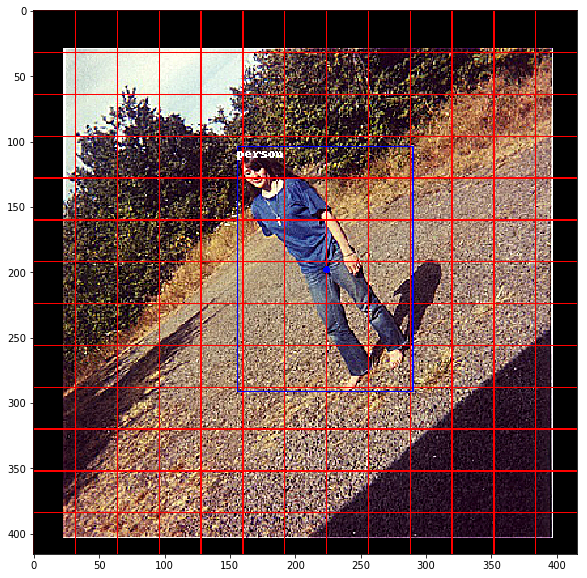

<PIL.Image.Image image mode=RGB size=416x416 at 0x7F4B5D4A6940> [[0.0, 0.48285181509762404, 0.458423560403986, 0.5714543244823749, 0.5453012781007982], [0.0, 0.34564493245333083, 0.3220350929868824, 0.13872355127577476, 0.16446484513437964], [14.0, 0.3857471578373131, 0.6939161547756412, 0.05347486015441842, 0.18320619107227817], [14.0, 0.05023469397315715, 0.6143529858931951, 0.05347486015441845, 0.18320619107227817]]


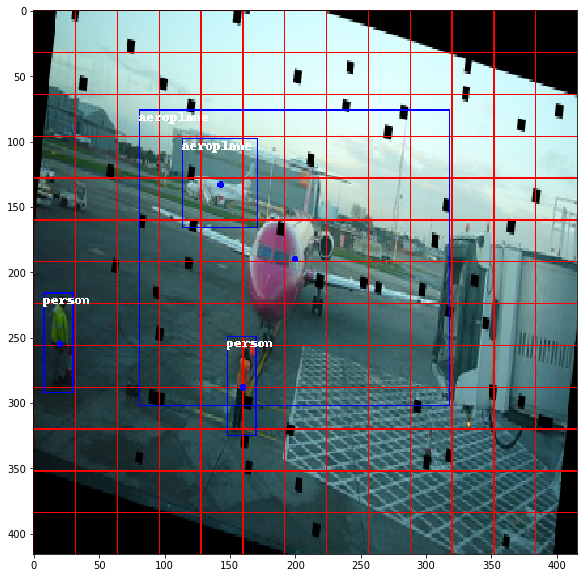

<PIL.Image.Image image mode=RGB size=416x416 at 0x7F4B5D3BE5F8> [[0.0, 0.508, 0.505464480874317, 0.98, 0.4262295081967213], [0.0, 0.903, 0.5819672131147541, 0.122, 0.07103825136612021], [0.0, 0.736, 0.5614754098360656, 0.172, 0.09562841530054644]]


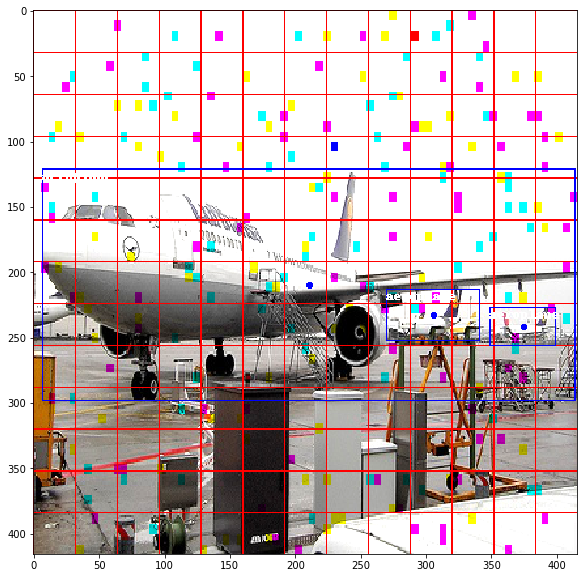

<PIL.Image.Image image mode=RGB size=416x416 at 0x7F4B5D4A6940> [[19.0, 0.5006139273140077, 0.4908470061312554, 0.4132122518737211, 0.5557040592537356]]


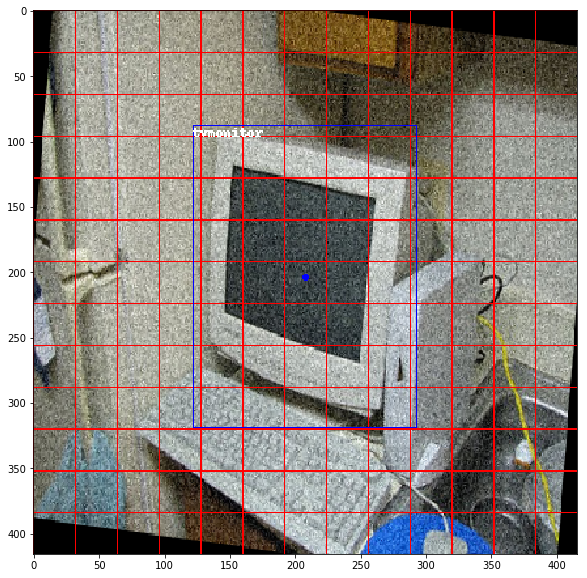

<PIL.Image.Image image mode=RGB size=416x416 at 0x7F4B5D0E7E10> [[18.0, 0.7361084498611933, 0.5563457828344922, 0.5277831002776132, 0.8873084343310155], [18.0, 0.2625367410790189, 0.43747166530787573, 0.5250734821580378, 0.8749433306157515]]


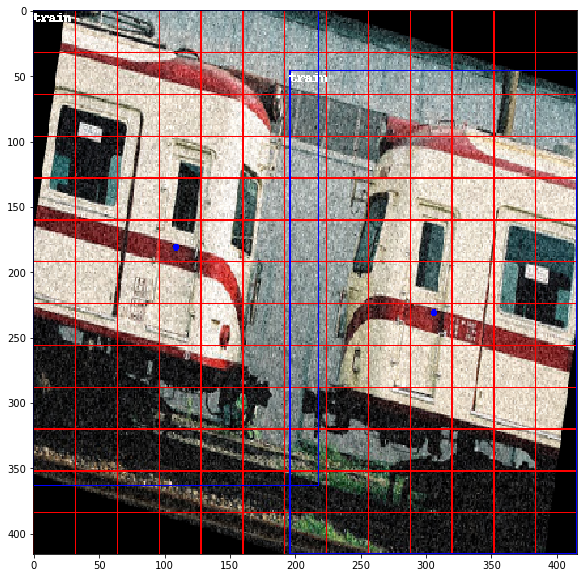

<PIL.Image.Image image mode=RGB size=416x416 at 0x7F4B5D4A6940> [[3.0, 0.711, 0.43543543543543545, 0.326, 0.8048048048048048], [3.0, 0.465, 0.6996996996996997, 0.194, 0.11411411411411411]]


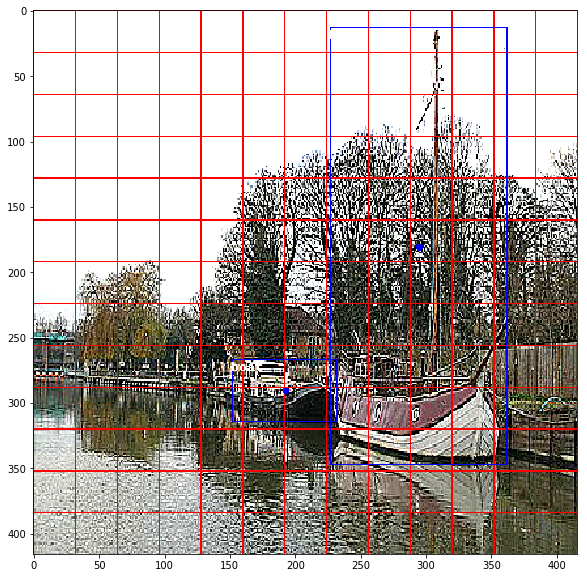

<PIL.Image.Image image mode=RGB size=416x416 at 0x7F4B5D0E7E10> [[11.0, 0.5077, 0.5445333333333333, 0.46080000000000004, 0.384], [8.0, 0.5085999999999999, 0.5277333333333333, 0.6354, 0.8976000000000001]]


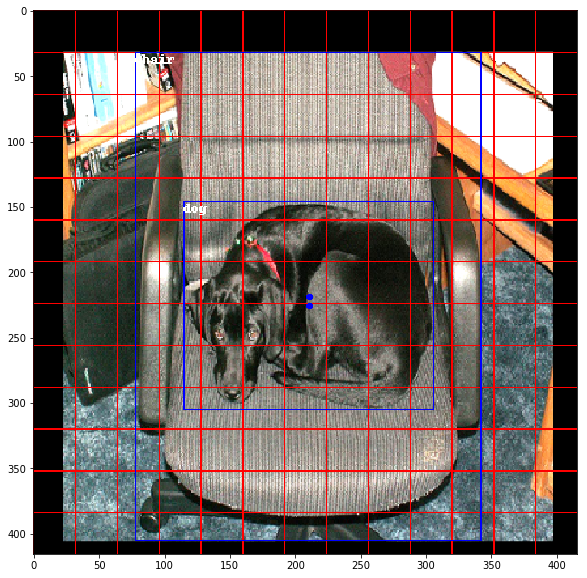

<PIL.Image.Image image mode=RGB size=416x416 at 0x7F4B5D4A6940> [[2.0, 0.293, 0.56, 0.478, 0.88]]


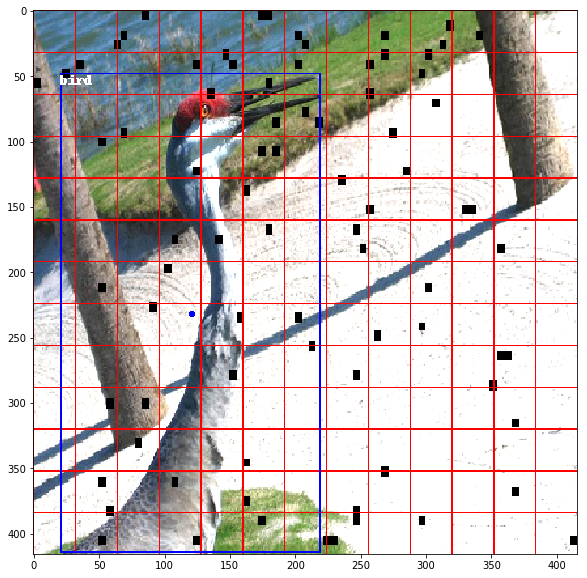

<PIL.Image.Image image mode=RGB size=416x416 at 0x7F4B5D0E7E10> [[19.0, 0.7092999999999999, 0.4305333333333333, 0.4032, 0.5736000000000001], [19.0, 0.3016, 0.43773333333333325, 0.41220000000000007, 0.588]]


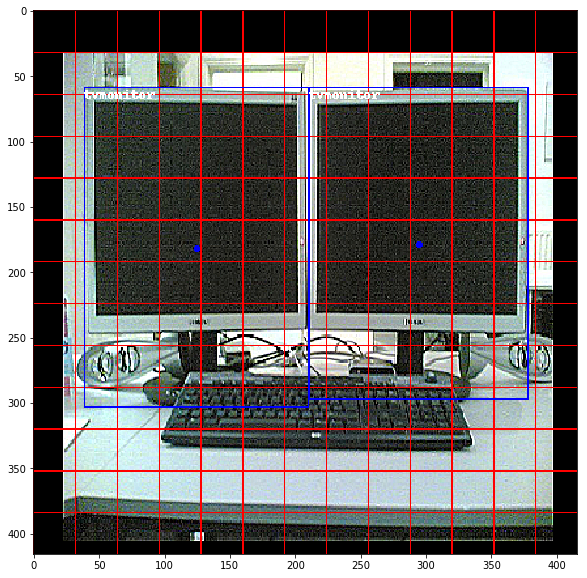

<PIL.Image.Image image mode=RGB size=416x416 at 0x7F4B5A30A320> [[18.0, 0.359, 0.488, 0.714, 0.8373333333333334]]


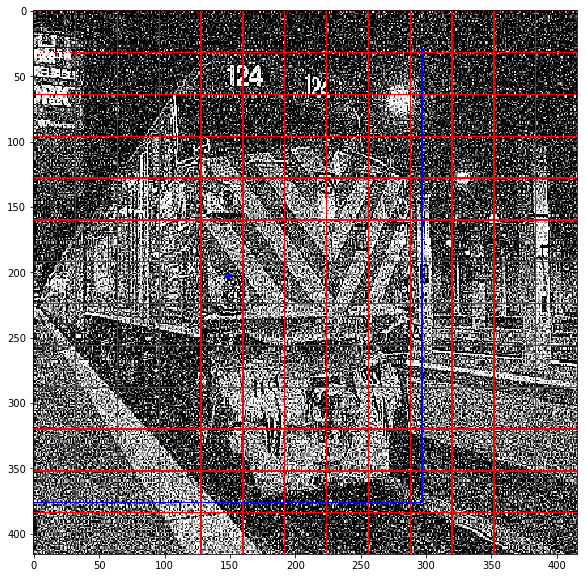

In [14]:
# Augmentation Demo
seq = iaa.SomeOf(2, [
            iaa.Multiply((1.2, 1.5)),  # change brightness, doesn't affect BBs
            iaa.Affine(
                translate_px={"x": 3, "y": 10},
                scale=(0.9, 0.9)
            ),  # translate by 40/60px on x/y axis, and scale to 50-70%, affects BBs
            iaa.AdditiveGaussianNoise(scale=0.1 * 255),
            iaa.CoarseDropout(0.02, size_percent=0.15, per_channel=0.5),
            iaa.Affine(rotate=(-45, 40)),
            iaa.Sharpen(alpha=0.5)
])

composed = transforms.Compose([Augmenter(seq)])

voc = VocDetection(root, transform=composed)
for i in range(10):
    image, target = voc.__getitem__(i)
    print(image, target)
    visualize_detection_label(image, target, voc.classes_list, (13, 13))